### Исследование влияния Dropout(p) на датасете CIFAR

---




### **Обновленное задание по 6-й лабораторной работе** 

На предыдущей лабораторной работе при обучении последнего варианта модели, включающая в себя батч-нормализацию, наблюдалось быстрое достижение оптимального минимума функции потерь (см. график 2 в данном ноутбуке). Однако, после этого следовало резкое переобучение модели.

В данной лабораторной работе предлагается исследовать влияние *Dropout(p)* при разных параметрах p, **(сохраняя при этом батч-нормализацию в модели)** . Провести сравнительный анализ того:


1.   как влияет *Dropout(p)* при разных p=[0.3,0.4,0.5]
2.   как влияет *Dropout(p)* при повышенных разных p=[0.6,0.7,0.8]

Также предлагается исследовать на каких слоях лучше всего *Dropout(p)* оптимизирует работу нейронной сети и улучшает ее качество обучения. Принято считать, что между предпоследнем и последнем слоях *Dropout(p)* лучше всего оказывает свой положительный эффект. Так ли это?

*Примечание: принято использовать следующий порядок при построении глубоких нейронных сетей: 

**[Скрытый слой] -> Батч-нормализация() -> Функция_активации() -> Dropout(p)**

In [ ]:
import torchvision.datasets
import torch

import torchvision.transforms as transforms
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=transform)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(CIFAR_train, batch_size=128, shuffle=True) 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    torch.cat((torch.FloatTensor(CIFAR_train.data) ,torch.FloatTensor(CIFAR_test.data)),0), 
    torch.cat((torch.LongTensor(CIFAR_train.targets) ,torch.LongTensor(CIFAR_test.targets)), 0), 
    test_size= 0.2, 
    random_state=42)

In [ ]:
#X_train = torch.FloatTensor(CIFAR_train.data) 
#y_train = torch.LongTensor(CIFAR_train.targets) 
#X_test = torch.FloatTensor(CIFAR_test.data) 
#y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)

(48000, 12000)

In [ ]:
X_train.min(), X_train.max()


(tensor(0.), tensor(255.))

In [ ]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(3) tensor(5) tensor(6) tensor(6) tensor(2) tensor(0) tensor(7) tensor(2) tensor(2) tensor(6) 

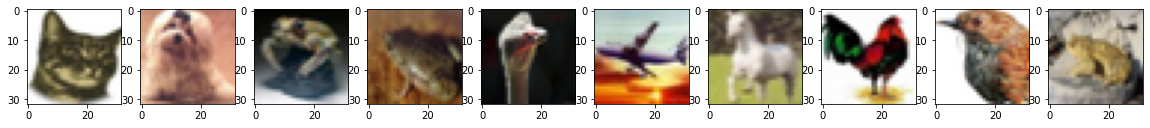

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    plt.imshow(X_train[i]) 
    print(y_train[i], end=' ')

In [ ]:
X_train.shape, y_train.shape


(torch.Size([48000, 32, 32, 3]), torch.Size([48000]))

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.reshape(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x


In [ ]:
"""
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

lenet5 = LeNet5()
lenet5.apply(init_weights)
"""

'\ndef init_weights(m):\n    if type(m) == torch.nn.Linear:\n        torch.nn.init.xavier_normal(m.weight)\n        m.bias.data.fill_(0.01)\n\nlenet5 = LeNet5()\nlenet5.apply(init_weights)\n'

In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    #best_test_loss = float('inf')
    #best_test_acc = 0
    #best_epoch_i = 0
    #early_stopping_patience = 10
    #best_lenet5 = copy.deepcopy(net)

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(32):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
            
        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)
        
        test_loss = loss(test_preds, y_test).data.cpu()
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()

        test_loss_history.append(test_loss)
        test_accuracy_history.append(accuracy)
        
        print(accuracy)

        """
        if accuracy > best_test_acc:
            best_epoch_i = epoch
            best_test_acc = accuracy
            #best_lenet5 = copy.deepcopy(net)


            print('Новая лучшая модель!')
        elif epoch - best_epoch_i > early_stopping_patience:
            print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                early_stopping_patience))
            break
        """

    #del net
    return test_accuracy_history, test_loss_history

In [ ]:
accuracies = {}
losses = {}

In [ ]:

"""
accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
"""

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)


tensor(0.4638)
tensor(0.5086)
tensor(0.5620)
tensor(0.6089)
tensor(0.6066)
tensor(0.6310)
tensor(0.6157)
tensor(0.6148)
tensor(0.6267)
tensor(0.6231)
tensor(0.6183)
tensor(0.6233)
tensor(0.6241)
tensor(0.6206)
tensor(0.6214)
tensor(0.6219)
tensor(0.6178)
tensor(0.6170)
tensor(0.6123)
tensor(0.6151)
tensor(0.6143)
tensor(0.6059)
tensor(0.6064)
tensor(0.6097)
tensor(0.6093)
tensor(0.6068)
tensor(0.6054)
tensor(0.6080)
tensor(0.5994)
tensor(0.5939)
tensor(0.5984)
tensor(0.5971)


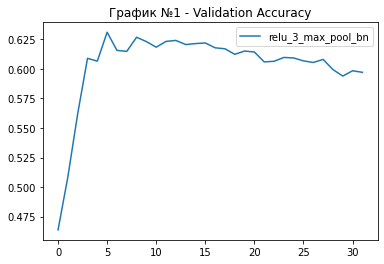

In [ ]:
##
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)

plt.legend()
plt.title('График №1 - Validation Accuracy');
##

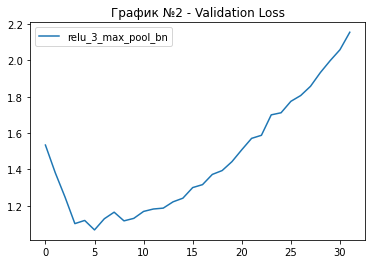

In [ ]:
##
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
    
plt.legend()
plt.title('График №2 - Validation Loss');
##